In [29]:
import numpy as np
import pickle as pickle

In [30]:
deapSubList=['01','02','03','04','05','06','07','08','09','10','11','12','13','14',\
         '15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31','32']

In [31]:
# 读取Deap数据 ,
#deap的eeg_data,egg_baseline_data,other_data,other_baseline_data,labels
def deap_read(deapSubs):
        sub=np.load('../eeg_to_1020/1020sub'+deapSubs+'.npy',allow_pickle=True).item()
        eeg_features=sub['eeg_features']
        other_features=sub['other_features']  
        labels=sub01['labels']  
        return eeg_features,other_features,labels

In [32]:
# 测试代码
sub01=np.load('../eeg_to_1020/1020sub'+ '02' +'.npy',allow_pickle=True).item()
eeg_features=sub01['eeg_features']
other_features=sub01['other_features']  
labels=sub01['labels']  

In [33]:
eeg_features.shape,other_features.shape,labels.shape

((40, 7680, 9, 9), (40, 8, 7680), (40, 2))

In [34]:
# 进行eeg信号的窗口分割
def deap_deal(eeg_features):
    
    #处理deap基线信号
    deap_split=np.zeros((40,60,128,9,9))
    for i in range(40):
        windows = 128//1
        part = 60
        baseli = np.stack(np.split( eeg_features[i] , part , axis=0)) 
        deap_split[i] = baseli
    return deap_split

In [35]:
sub01_data = deap_deal(eeg_features)
print(sub01_data.shape)

(40, 60, 128, 9, 9)


In [36]:
sub01_data.shape[2:]

(128, 9, 9)

In [37]:
#labels

In [38]:
# 把特征也做成这个形状
# 这个只能把1280,1形状的标签转换为alpha特征形状一致
def label_deal(labels):
    templabel = np.zeros((40,60,2))
    for i in range(40):
        for j in range(60):
                templabel[i][j] = labels[i]
    return templabel

In [39]:
# 把特征做成softmax需要的格式
def to_softmax(label):
    softmax_label = np.zeros((2400,2))
    #两列，第一列表示他是正例，第二例表示他是反例
    for i in range(2400):
        if label[i] ==1 :
            softmax_label[i][0] = 1
        else:
            softmax_label[i][1] = 1
    return softmax_label

In [40]:
#划分训练集和测试集，标签也进行划分
def data_split(feature,labels):
    #前两维压压平，后三维压平
    x_train = feature[:39,:,:,:,:].reshape((2340,*feature.shape[2:])).reshape((2340,-1)) #训练集划分
    x_test = feature[39:,:,:,:,:].reshape((60,-1))
    #弄成1dcnn需要的形式
    x_train = x_train.reshape((*x_train.shape,1))
    x_test = x_test.reshape((*x_test.shape,1))
    labels = np.where(labels>5 , 1 , 0)
    labels = label_deal(labels).reshape((-1,2))
    #把标签做成softmax回归的模式
    vlabel = labels[:,:-1]
    alabel = labels[:,-1:]
    vlabel = to_softmax(vlabel)
    alabel = to_softmax(alabel)
    print(vlabel.shape)
    print(alabel.shape)
    vy_train = vlabel[:2340,:]
    vy_test = vlabel[2340:,:]
    ay_train = alabel[:2340,:]
    ay_test = alabel[2340:,:]
    return x_train,x_test,vy_train,vy_test,ay_train,ay_test

In [41]:
x_train,x_test,vy_train,vy_test,ay_train,ay_test = data_split(sub01_data,labels)

(2400, 2)
(2400, 2)


In [42]:
x_train.shape,x_test.shape,vy_train.shape,vy_test.shape,ay_train.shape,ay_test.shape

((2340, 10368, 1), (60, 10368, 1), (2340, 2), (60, 2), (2340, 2), (60, 2))

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow import keras
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [44]:
# #创建四层全连接层模型
# def create_model():
#     #init=keras.initializers.glorot_normal(seed=1)
#     simple_adam=keras.optimizers.Adam()
#     model=keras.models.Sequential()
#     model.add(keras.layers.GRU(units=64,
#                                 recurrent_activation='sigmoid',
#                                 reset_after=True,
#                                 input_shape=(10368,1)))
#     #model.add(keras.layers.Dropout(0.2))
#     model.add(keras.layers.Dense(units=64,activation='relu'))
#     model.add(keras.layers.Dense(units=32,activation='relu'))
#     model.add(keras.layers.BatchNormalization())
#     model.add(keras.layers.Dense(units=1,activation='sigmoid'))
#     #优化器的metrics改成keras.metrics.binary_accuracy试一试
#     model.compile(loss='binary_crossentropy',optimizer=simple_adam,metrics=['accuracy'])
#     return model

def create_model():
    model = Sequential()
    simple_adam=keras.optimizers.Adam()
    model.add(layers.Conv1D(128,81,activation='relu',   #提取一个采样点的所有脑电图的卷积信息，输出为128即采样点数，之后可以看成是一个时间序列
                           input_shape=(10368,1)))      #可以关注到信号的的整体空间信息
    #model.add(layers.MaxPool1D(9))
    #用全局平均值池化试一试 ,全局平均值池化好像强一点
    #model.add(layers.AveragePooling1D(9))
#     model.add(layers.Conv1D(32,9,activation='relu'))
#     model.add(layers.MaxPool1D(3))
    #,dropout = 0.5
    model.add(layers.GRU(32))                            #用卷积层提取的时间序列，GRU进行训练，GRU正好可以根据时间序列进行记忆
    model.add(keras.layers.Dense(units=16,activation='relu'))  #利用这个模型可以提取电脑信号不同时间的联系
    model.add(keras.layers.BatchNormalization())
    model.add(layers.Dense(2,activation='softmax'))
    model.compile(loss='binary_crossentropy',optimizer=simple_adam,metrics=['accuracy'])
    return model

In [45]:
model = create_model()

In [46]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 10288, 128)        10496     
_________________________________________________________________
gru_3 (GRU)                  (None, 32)                15552     
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
batch_normalization_3 (Batch (None, 16)                64        
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 34        
Total params: 26,674
Trainable params: 26,642
Non-trainable params: 32
_________________________________________________________________


In [47]:
history = model.fit(x_train,vy_train,epochs=20,batch_size=32,validation_data=(x_test,vy_test))

Epoch 1/20
74/74 [==============================] - 24s 209ms/step - loss: 0.6826 - accuracy: 0.5684 - val_loss: 0.7963 - val_accuracy: 0.0833
Epoch 2/20
74/74 [==============================] - 15s 205ms/step - loss: 0.6516 - accuracy: 0.6171 - val_loss: 0.6488 - val_accuracy: 0.9500
Epoch 3/20
74/74 [==============================] - 15s 206ms/step - loss: 0.6367 - accuracy: 0.6278 - val_loss: 0.5541 - val_accuracy: 0.9667
Epoch 4/20
74/74 [==============================] - 15s 206ms/step - loss: 0.6199 - accuracy: 0.6543 - val_loss: 0.9141 - val_accuracy: 0.1000
Epoch 5/20
74/74 [==============================] - 15s 205ms/step - loss: 0.6060 - accuracy: 0.6632 - val_loss: 0.6823 - val_accuracy: 0.5667
Epoch 6/20
74/74 [==============================] - 15s 205ms/step - loss: 0.5891 - accuracy: 0.6803 - val_loss: 1.0267 - val_accuracy: 0.1667
Epoch 7/20
74/74 [==============================] - 15s 205ms/step - loss: 0.5902 - accuracy: 0.6718 - val_loss: 0.5535 - val_accuracy: 0.9333

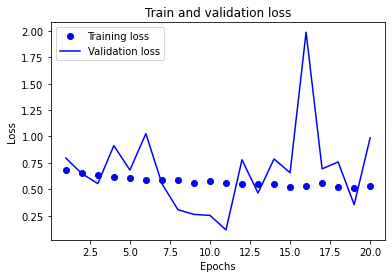

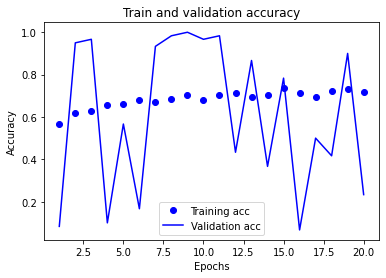

In [48]:

#画图(损失)
history_dict=history.history
loss_values=history_dict['loss']
val_loss_values=history_dict['val_loss']

epochs=range(1,len(loss_values)+1)

plt.plot(epochs,loss_values,'bo',label='Training loss')  #'bo'表示蓝色圆点
plt.plot(epochs,val_loss_values,'b',label='Validation loss') #'b' 表示蓝色实线
plt.title("Train and validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#画图（准确度）
plt.clf()  #清空图像
acc=history_dict['accuracy']
val_acc=history_dict['val_accuracy']

plt.plot(epochs,acc,'bo',label='Training acc')  #'bo'表示蓝色圆点
plt.plot(epochs,val_acc,'b',label='Validation acc') #'b' 表示蓝色实线
plt.title("Train and validation accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [49]:
model.evaluate(x_test,vy_test)

2/2 [==============================] - 0s 111ms/step - loss: 0.9870 - accuracy: 0.2333


[0.9870263338088989, 0.23333333432674408]

In [ ]:
#保存模型
model.save('./model/OneCNN81_GRU.h5')